# Fabio Tatti s282383

Collaborated with: ("Andrea Silvi", "s290312"), ("Andrea Rizzardi", "s287396"), ("Maria Francesca Turco", "s278427")

# Exercise 1
## Point 1 - Epidemic on a known graph


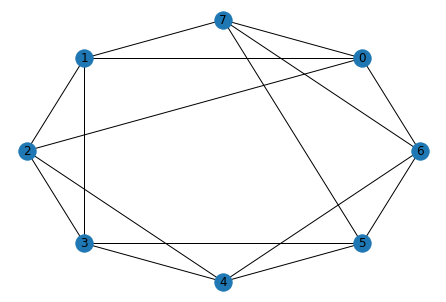

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math



def build_symmetric_graph(num_nodes, degree):
    nodes = list(range(num_nodes))
    G = nx.Graph()
    for i in range(num_nodes):
        sums = np.arange(-degree//2,(degree//2) + 1 )
        
        #create connections
        for j in sums:
            if j != 0 and i<num_nodes-degree//2:
                G.add_edge(nodes[i+j],nodes[i])
                
        #link only the remaining last degree//2 nodes to each other
        if i>(num_nodes - degree // 2):
            G.add_edge(nodes[i-1],nodes[i])
    return G

#we print an example graph with only 8 nodes
G = build_symmetric_graph(8, 4)
pos = nx.drawing.layout.circular_layout(G)
nx.draw(G,pos,with_labels=True)

In [2]:
import random

def get_neighbours(G,node):
    #function to get the list of neighbour nodes
    neigh = [n for n in G.neighbors(node)]
    return neigh


def get_infected_neighbours(G,node,node_state):
    #returns only the infected neighbours of the node
    neigh = get_neighbours(G,node)
    final =[]
    for n in neigh:
        if n in node_state["I"]:
            final.append(n)
    return final


def number_SI_links(G, node_state, nodes, state_A = "S", state_B = "I"):
    #counts the number of links given two states
    counter = 0
    #we iterate over the state b nodes to check the neighbours
    for n in node_state[state_B]:
        neigh = get_neighbours(G, n)
        for j in neigh:
            if j in node_state[state_A]:
                counter += 1
    return counter

def move_from (node_state, nodes_sel, key_from, key_to):
    #move the given selection of nodes from a key to another of the node_state dictionary
    #this means that a node transit from a state to another:
    #e.g. -> from susceptibles to infected
    
    node_states = node_state.copy()
    for i in nodes_sel:
        node_states[key_from].remove(i)
        node_states[key_to].append(i)
    return node_states

In [4]:

def simulate_infection(G,initial_number_infected):
    #simulate pandemic over a graph with no vaccination
    
    #initialization
    
    #the returned result array
    res = []

    nodes = list(range(num_nodes))
    node_state = {"S" : nodes.copy(), "I": [], "R":[]}
    initial_infected_nodes = random.sample(nodes, initial_number_infected)
    node_state = move_from(node_state,initial_infected_nodes, "S","I" )

    #counter of links between susceptibles and infected
    B = number_SI_links(G,node_state,nodes)

    #counter of infected from the beginning of the process
    I = initial_number_infected
    
    #append the initial state to the results(we also plot it in the charts)
    susceptibles = len(node_state["S"])
    infected = len(node_state["I"])
    recovered = len(node_state["R"])
    res.append([0, I,B,susceptibles, infected, recovered ])
    
    #iterate over weeks
    for week in range(tot_weeks):
        
        #initialization of week
        new_infected = []
        new_recovered = []

        for s in node_state["S"]:
            #compute the probability of this node to become infected
            #get the list of infected neighbours
            
            inf_neigh = get_infected_neighbours(G, s, node_state)
            prob_inf = 1 - pow((1-beta), len(inf_neigh))
            dist = [prob_inf, 1-prob_inf]
            
            #choose randomly given the probability if the nodes gets infected or not
            
            infection = np.random.choice([True,False],1, p = dist)[0]
            if infection:
                new_infected.append(s)

        for i in node_state["I"]:
            #compute the probability of this node to recover from infection
            
            prob_recover = ro
            dist = [prob_recover, 1-prob_recover]
            recover = np.random.choice([True,False], 1, p = dist)[0]
            if recover:
                new_recovered.append(i)
        
        #we make the state transition for selected nodes
        node_state = move_from(node_state, new_infected, "S","I")
        node_state = move_from(node_state, new_recovered, "I","R")

        #append the partial result of the week to the final result array
        B = number_SI_links(G,node_state,nodes)
        I = len(new_infected)
        susceptibles = len(node_state["S"])
        infected = len(node_state["I"])
        recovered = len(node_state["R"])


        #[week, new infected, number infection links, tot subsceptibles, tot infected, tot recovered]
        res.append([week + 1, I,B,susceptibles, infected, recovered])

    return res

In [5]:

#now we simulate the infection for 100 times in order to get the average of infection each week

num_nodes = 500
nodes = list(range(num_nodes))
k = 4

#prob of infection given a link between susceptible and infected
beta = 0.3
#prob of recovering for an infected node
ro = 0.7
tot_weeks = 15
#the 10 initial nodes infected are randomly selected from the nodes list
initial_infected_nodes = random.sample(nodes, 10)
#number of simulations
N = 100

#array to register all the data of the simulations
total_results = []
#we create the graph we simulate onto
G = build_symmetric_graph(num_nodes,k)

for n in range(N):
    
    single_results = simulate_infection(G,10)
    total_results.append(single_results)
    
final_results = {"new_every_week":[], "susceptible":[],"infected":[],"recovered":[]}
weeks = list(range(16))

#manage simulation data to merge by summing by week
for week in range(16):
    tot_new_infection = 0
    tot_susceptible = 0
    tot_infected = 0
    tot_recovered = 0
    
    for n in range(N):
        tot_new_infection += total_results[n][week][1]
        tot_susceptible += total_results[n][week][3]
        tot_infected += total_results[n][week][4]
        tot_recovered += total_results[n][week][5]
    
    final_results["new_every_week"].append(tot_new_infection)
    final_results["susceptible"].append(tot_susceptible)
    final_results["infected"].append(tot_infected)
    final_results["recovered"].append(tot_recovered)

#averaging over total runs
final_results["new_every_week"] = [x / N for x in final_results["new_every_week"]]
final_results["susceptible"] = [x / N for x in final_results["susceptible"]]
final_results["infected"] = [x / N for x in final_results["infected"]]
final_results["recovered"] = [x / N for x in final_results["recovered"]]

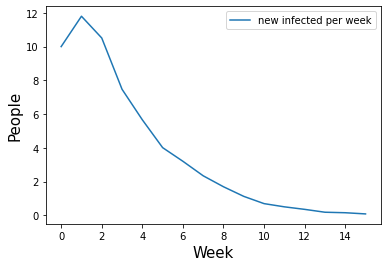

In [6]:
#plot the chart of the new infected per week
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["new_every_week"], label = "new infected per week")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

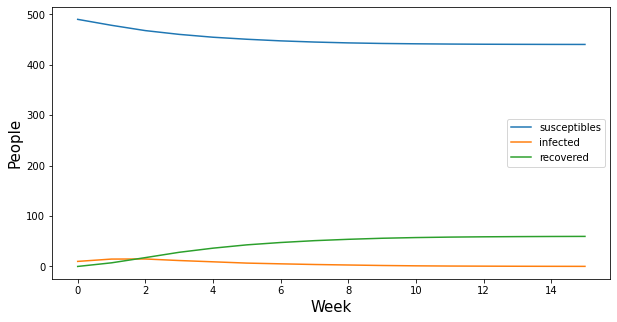

In [7]:
#plot the chart for subsceptibles, infected and recovered per week
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["susceptible"], label = "susceptibles")
plt.plot(final_results["infected"], label = "infected")
plt.plot(final_results["recovered"], label = "recovered")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

## Point 2 - Generate a Random Graph
Using the preferential attachment model we want a random graph with average degree close to k = 4. We generate a random graph with 2000 nodes

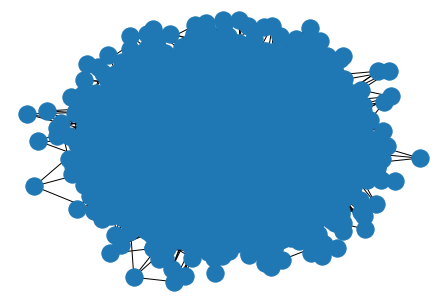

In [3]:
def gen_random_graph(num_nodes, k):
    #we start the procedure by creating a complete graph with k+1 nodes
    G = nx.generators.classic.complete_graph(k+1)
    #each time we add a new node to the graph 
    alternate = False
    for i in range(num_nodes-k-1):
        new_node = k+1+i
        G.add_node(new_node)     
        degrees = [d for n,d in G.degree()][:-1]
        tot_degree = np.sum(degrees)
        
        #these will be the positive probability that all previously created nodes will have a
        #edge connecting with the new one
        prob_pos = [x / tot_degree for x in degrees]
        #print(len(np.arange(k)), len(prob_pos))
        #print(prob_pos)
        if k%2 == 0:
            chosen_nodes = np.random.choice(k+i+1,k//2, p = prob_pos, replace = False)
        #to deal with the odd k 
        elif alternate:
            chosen_nodes = np.random.choice(k+i+1,k//2, p = prob_pos, replace = False)
            alternate = False

        else:
            chosen_nodes = np.random.choice(k+i+1,k//2 +1, p = prob_pos, replace = False)
            alternate = True

            
        for c in chosen_nodes:
                G.add_edge(new_node, c)       

       
    return G

k = 7
num_nodes = 2000
G = gen_random_graph(num_nodes, k)
pos = nx.drawing.layout.spring_layout(G)
nx.draw(G,with_labels=False)


In [4]:
print(f"Proof: given k is {k} and the average obtained from G is {np.mean(list(dict(G.degree()).values()))}")

Proof: given k is 7 and the average obtained from G is 7.0


# Exercise 2
Generate a random graph with 500 nodes with average degree k = 6. 

In [10]:
k = 6
num_nodes = 500

#we create the graph we simulate onto
G = gen_random_graph(num_nodes, k)

#array to register all the data of the simulations
total_results = []
N = 100
for n in range(N):
    single_results = simulate_infection(G,10)
    total_results.append(single_results)
    
final_results = {"new_every_week":[], "susceptible":[],"infected":[],"recovered":[]}
weeks = list(range(16))

#manage simulation data to merge by summing by week

for week in range(16):
    tot_new_infection = 0
    tot_susceptible = 0
    tot_infected = 0
    tot_recovered = 0
    
    for n in range(N):
        tot_new_infection += total_results[n][week][1]
        tot_susceptible += total_results[n][week][3]
        tot_infected += total_results[n][week][4]
        tot_recovered += total_results[n][week][5]
    
    final_results["new_every_week"].append(tot_new_infection)
    final_results["susceptible"].append(tot_susceptible)
    final_results["infected"].append(tot_infected)
    final_results["recovered"].append(tot_recovered)

#averaging over total runs
final_results["new_every_week"] = [x / N for x in final_results["new_every_week"]]
final_results["susceptible"] = [x / N for x in final_results["susceptible"]]
final_results["infected"] = [x / N for x in final_results["infected"]]
final_results["recovered"] = [x / N for x in final_results["recovered"]]



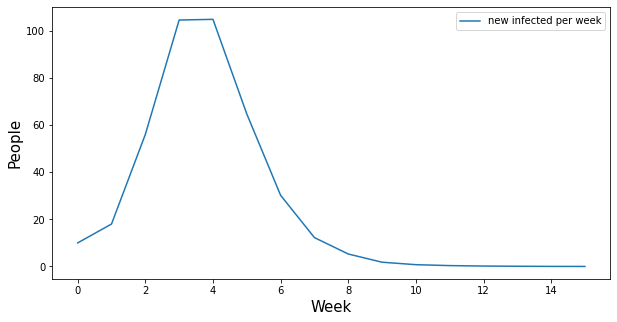

In [11]:
#plot the chart of the new infected per week
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["new_every_week"], label = "new infected per week")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

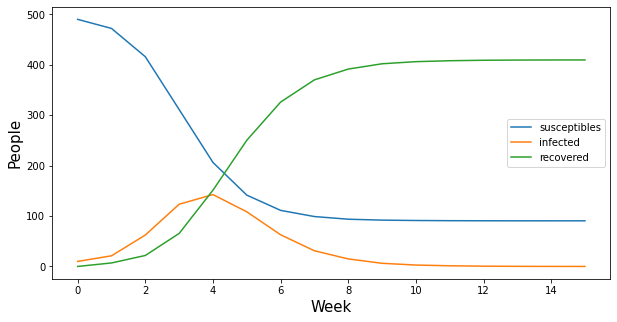

In [12]:
#plot the chart for subsceptibles, infected and recovered per week
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["susceptible"], label = "susceptibles")
plt.plot(final_results["infected"], label = "infected")
plt.plot(final_results["recovered"], label = "recovered")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

# Exercise 3
We simulate again but introducing the vaccine for a fraction of the population

In [5]:
 
def move_vaccine (node_state, nodes_sel):
    #move the given selected nodes from a key to the vaccinated of the node_state dictionary
    node_states = node_state.copy()
    sub = []
    inf = []
    rec = []
    for i in nodes_sel:
        if i in node_state["S"]:
            sub.append(i)
        elif i in node_state["I"]:
            inf.append(i)
        elif i in node_state["R"]:
            rec.append(i)
    
    node_states = move_from(node_state, sub, "S","V")
    node_states = move_from(node_state, inf, "I","V")
    node_states = move_from(node_state, rec, "R","V")
    return node_states

def simulate_infection_vaccine(G,initial_number_infected, vaccinated):
    #simulate pandemic over a graph with vaccination

    #initialization
    #the returned result array

    res = []

    nodes = list(range(num_nodes))
    #we introduce the new state V for vaccinated
    node_state = {"S" : nodes.copy(), "I": [], "R":[], "V":[]}
    initial_infected_nodes = random.sample(nodes, initial_number_infected)
    node_state = move_from(node_state,initial_infected_nodes, "S","I" )
    
    

    #counter of links between susceptibles and infected
    B = number_SI_links(G,node_state,nodes)

    #counter of infected from the beginning of the process
    I = initial_number_infected
    
    susceptibles = len(node_state["S"])
    infected = len(node_state["I"])
    recovered = len(node_state["R"])
    vaccina = len(node_state["V"])
    
    #append the initial state to the results(we also plot it in the charts)
    res.append([0, initial_number_infected,B,susceptibles, infected, recovered, vaccina, 0 ])
    currently_vaccinated = 0
    people_with_no_vaccine = np.arange(num_nodes)
    
    #iterate over the weeks
    for week in range(tot_weeks):
        
        #number of people that will receive the vaccine in this week becoming immune
        n_vaccines = int((vaccinated[week] - currently_vaccinated) * num_nodes / 100)
        
        #selection of vaccined people among not vaccined
        new_vaccinated = np.random.choice(people_with_no_vaccine, n_vaccines, replace = False)
        #move vaccinated nodes
        node_state = move_vaccine(node_state, new_vaccinated)
        new_people_with_no_vaccine = []
        
        for x in people_with_no_vaccine:
            if x not in new_vaccinated:
                new_people_with_no_vaccine.append(x)
        people_with_no_vaccine = new_people_with_no_vaccine.copy()
        currently_vaccinated += vaccinated[week] - currently_vaccinated

        
        new_infected = []
        new_recovered = []

        for s in node_state["S"]:
            #compute the probability of this node to become infected
            #get the list of infected neighbours
            inf_neigh = get_infected_neighbours(G, s, node_state)
            prob_inf = 1 - pow((1-beta), len(inf_neigh))
            dist = [prob_inf, 1-prob_inf]
            #choose randomly given the probability if the nodes gets infected or not
            infection = np.random.choice([True,False],1, p = dist)[0]
            if infection:
                new_infected.append(s)

        for i in node_state["I"]:
            #compute the probability of this node to recover from infection
            prob_recover = ro
            dist = [prob_recover, 1-prob_recover]
            recover = np.random.choice([True,False], 1, p = dist)[0]
            if recover:
                new_recovered.append(i)

        #we make the state transition for selected nodes
        node_state = move_from(node_state, new_infected, "S","I")
        node_state = move_from(node_state, new_recovered, "I","R")

        #append the partial result of the week to the final result array
        B = number_SI_links(G,node_state,nodes)
        I = len(new_infected)
        susceptibles = len(node_state["S"])
        infected = len(node_state["I"])
        recovered = len(node_state["R"])
        vaccina = len(node_state["V"])
        new_vaccina = n_vaccines
        
        #[week, new_infected_week, link_infection, subsceptibles, infected, recovered, vaccinated, new_vaccinated]
        res.append([week + 1, I,B,susceptibles, infected, recovered, vaccina, new_vaccina])

    return res

In [8]:
#is the fraction of the population which had received the vaccine at the given week
vaccinated =  [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

k = 6
num_nodes = 500
tot_weeks = 15
beta = 0.3
ro = 0.7
G = gen_random_graph(num_nodes, k)
N = 100

#the array to manage the data returned by the iterative simulation
total_results = []
for n in range(N):
    
    single_results = simulate_infection_vaccine(G,10, vaccinated)
    total_results.append(single_results)
    
final_results = {"new_every_week":[], "susceptible":[],"infected":[],"recovered":[], "vaccinated":[], "new_vaccinated":[]}
weeks = list(range(16))

#now we merge the data by summing by week
for week in range(16):
    tot_new_infection = 0
    tot_susceptible = 0
    tot_infected = 0
    tot_recovered = 0
    tot_vaccinated = 0
    tot_new_vaccinated = 0
    
    for n in range(N):
        tot_new_infection += total_results[n][week][1]
        tot_susceptible += total_results[n][week][3]
        tot_infected += total_results[n][week][4]
        tot_recovered += total_results[n][week][5]
        tot_vaccinated += total_results[n][week][6]
        tot_new_vaccinated += total_results[n][week][7]


    
    final_results["new_every_week"].append(tot_new_infection)
    final_results["susceptible"].append(tot_susceptible)
    final_results["infected"].append(tot_infected)
    final_results["recovered"].append(tot_recovered)
    final_results["vaccinated"].append(tot_vaccinated)
    final_results["new_vaccinated"].append(tot_new_vaccinated)


#averaging over total runs
final_results["new_every_week"] = [x / N for x in final_results["new_every_week"]]
final_results["susceptible"] = [x / N for x in final_results["susceptible"]]
final_results["infected"] = [x / N for x in final_results["infected"]]
final_results["recovered"] = [x / N for x in final_results["recovered"]]
final_results["vaccinated"] = [x / N for x in final_results["vaccinated"]]
final_results["new_vaccinated"] = [x / N for x in final_results["new_vaccinated"]]

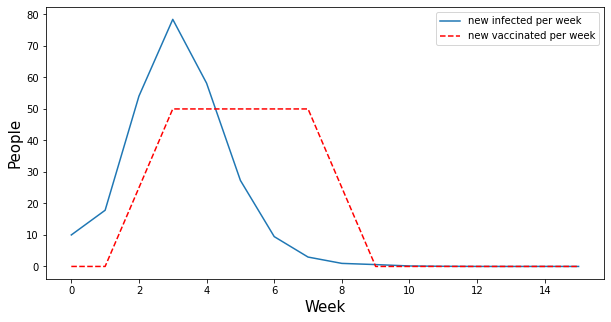

In [9]:
#plot the chart of the new infected and vaccinated per week 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["new_every_week"], label = "new infected per week")
plt.plot(final_results["new_vaccinated"], "r--",label = "new vaccinated per week")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

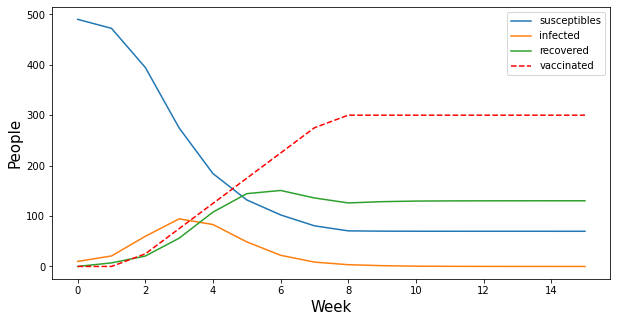

In [10]:
#plot the chart for subsceptibles, infected and recovered per week and new vaccinated
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["susceptible"], label = "susceptibles")
plt.plot(final_results["infected"], label = "infected")
plt.plot(final_results["recovered"], label = "recovered")
plt.plot(final_results["vaccinated"], "r--",label = "vaccinated")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

# Exercise 4
We now simulate the H1N1 pandemic in Sweden, for a population of 9 million people, scaled down of a factor 10000, resulting in a graph with 934 nodes

In [11]:

def RMSE(pred, true):
    #to compute the RMSE
    if len(pred) == len(true):
        tot = 0
        #the first entry is not considered since is always equal
        for i in range(1,len(pred)):
            part = pow((pred[i] - true[i]),2)
            tot += part
        tot = tot / len(pred)
        return math.sqrt(tot)
    else:
         print(f"The two list have not same lenght: pred is {len(pred)} and truth is {len(true)}")

In [ ]:
vaccinated = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
I = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
num_nodes = 934
initial_number_infected = I[0]
N = 10
#set a maximum number of iteration to prevent infinite looping
threshold_iterations = 40
#we set a threshold for the error, under which we stop the regression
threshold_precision = 0.1


#set the initial values of k, beta, rho
init_k = best_k = 10
init_beta = best_beta = 0.3
init_ro = best_ro = 0.6
print(f"\nInitial k:{best_k}\nInitial beta:{best_beta}\nInitial rho:{best_ro}")            

#set their deltas
delta_k = 1
delta_beta = 0.1
delta_ro = 0.1
#create their spaces
space_k = [init_k - delta_k, init_k, init_k + delta_k]
space_beta = [init_beta - delta_beta, init_beta, init_beta + delta_beta]
space_ro = [init_ro - delta_ro, init_ro, init_ro + delta_ro]

currently_overall_best = [100, init_k, init_beta, init_ro]
for it in range(threshold_iterations):
    
    #check on the spaces 
    if best_k + delta_k > num_nodes: del space_k[-1]
    if best_k - delta_k <= 0: del space_k[0]
    if best_beta + delta_beta > 1: del space_beta[-1]
    if best_beta - delta_beta <= 0: del space_beta[0]
    if best_ro + delta_ro > 1: del space_ro[-1]
    if best_ro - delta_ro <= 0: del space_ro[0]
    
    
    #to keep track of the various improvements
    whole_space_results = []

    #iterate over the 3 spaces
    for k in space_k:
        for beta in space_beta:
            for ro in space_ro:

                tot_results = []

                #now we iterate N times
                for n in range(N):

                    #we now generate a random graph 
                    G = gen_random_graph(num_nodes, k)
                    res = simulate_infection_vaccine(G, initial_number_infected, vaccinated )
                    #just to store infected
                    partial_result = []
                    for i in res:
                        partial_result.append(i[1])
                    tot_results.append(partial_result)

                #now we average the number of infected over the N iterations
                #sum over columns and then divide by N
                combination_result = [sum(x) for x in zip(*tot_results)] 
                combination_result = [x / N for x in combination_result]

                #compute the RMSE error respect the ground truth
                error = RMSE(combination_result, I)

                #we now append the result in array form in order to keep track of the partial result
                #[error, k, beta, ro]
                returning = [error, k, beta, ro]
                whole_space_results.append(returning)
    
    #now we want to find the best performing configuration of the parameters to set the new values
    min_conf_index = np.argmin(np.array(whole_space_results)[:,0])
    best_k = int(whole_space_results[min_conf_index][1])
    best_beta = whole_space_results[min_conf_index][2]
    best_ro = whole_space_results[min_conf_index][3]
    print(f"\nIteration :{it} | Best RMSE: {whole_space_results[min_conf_index][0]}")
    
    #create the new spaces (decrease the deltas in order get more precision)
    space_k = [best_k - delta_k, best_k, best_k + delta_k]
    space_beta = [best_beta - delta_beta/(it/2+1), best_beta, best_beta + delta_beta/(it/2+1)]
    space_ro = [best_ro - delta_ro/(it/2+1), best_ro, best_ro + delta_ro/(it/2+1)]
    print(f"\n     Configuration: k = {best_k}, beta = {best_beta}, rho = {best_ro }")

    if whole_space_results[min_conf_index][0] < currently_overall_best[0]:
        currently_overall_best = whole_space_results[min_conf_index]
        
    #if the RMSE drops under a given value we shut down the simulation
    if currently_overall_best[0] < threshold_precision:
        break
        
#print the best performing configuration for the parameters            
print(f"\nBest k:{currently_overall_best[1]}\nBest beta:{currently_overall_best[2]}\
\nBest rho:{currently_overall_best[3]} \nRMSE: {currently_overall_best[0]}")            
            



Initial k:10
Initial beta:0.3
Initial ro:0.6

Iteration :0 | Best RMSE: 8.877642916337646

     Configuration: k = 9, beta = 0.19999999999999998, ro = 0.7

Iteration :1 | Best RMSE: 5.755053757351011

     Configuration: k = 8, beta = 0.19999999999999998, ro = 0.7

Iteration :2 | Best RMSE: 6.267934268959751

     Configuration: k = 7, beta = 0.19999999999999998, ro = 0.6333333333333333

Iteration :3 | Best RMSE: 4.736676049720944

     Configuration: k = 8, beta = 0.19999999999999998, ro = 0.5833333333333333

Iteration :4 | Best RMSE: 5.013253060638371

     Configuration: k = 8, beta = 0.19999999999999998, ro = 0.5833333333333333

Iteration :5 | Best RMSE: 4.8344964836061255

     Configuration: k = 9, beta = 0.16666666666666666, ro = 0.5499999999999999

Iteration :6 | Best RMSE: 5.191621254483035

     Configuration: k = 9, beta = 0.16666666666666666, ro = 0.5499999999999999

Iteration :7 | Best RMSE: 4.695745414734492

     Configuration: k = 9, beta = 0.16666666666666666, ro = 0.

In [12]:
I = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
num_nodes = 934
tot_weeks = 15
N = 100
#is the fraction of the population which had received the vaccine at the given time
vaccinated = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]

#the values selected here are the best perfoming ones returned from our searches
k = 14
beta = 0.10813445131170563
ro = 0.4912506796819136
initial_number_infected = I[0]
total_results = []

for n in range(N):
    G = gen_random_graph(num_nodes, k)
    single_results = simulate_infection_vaccine(G,initial_number_infected, vaccinated)
    total_results.append(single_results)
    
final_results = {"new_every_week":[], "susceptible":[],"infected":[],"recovered":[], "vaccinated":[], "new_vaccinated":[]}
weeks = list(range(16))

for week in range(16):
    tot_new_infection = 0
    tot_susceptible = 0
    tot_infected = 0
    tot_recovered = 0
    tot_vaccinated = 0
    tot_new_vaccinated = 0
    
    for n in range(N):
        tot_new_infection += total_results[n][week][1]
        tot_susceptible += total_results[n][week][3]
        tot_infected += total_results[n][week][4]
        tot_recovered += total_results[n][week][5]
        tot_vaccinated += total_results[n][week][6]
        tot_new_vaccinated += total_results[n][week][7]


    
    final_results["new_every_week"].append(tot_new_infection)
    final_results["susceptible"].append(tot_susceptible)
    final_results["infected"].append(tot_infected)
    final_results["recovered"].append(tot_recovered)
    final_results["vaccinated"].append(tot_vaccinated)
    final_results["new_vaccinated"].append(tot_new_vaccinated)


#averaging over total runs
final_results["new_every_week"] = [x / N for x in final_results["new_every_week"]]
final_results["susceptible"] = [x / N for x in final_results["susceptible"]]
final_results["infected"] = [x / N for x in final_results["infected"]]
final_results["recovered"] = [x / N for x in final_results["recovered"]]
final_results["vaccinated"] = [x / N for x in final_results["vaccinated"]]
final_results["new_vaccinated"] = [x / N for x in final_results["new_vaccinated"]]

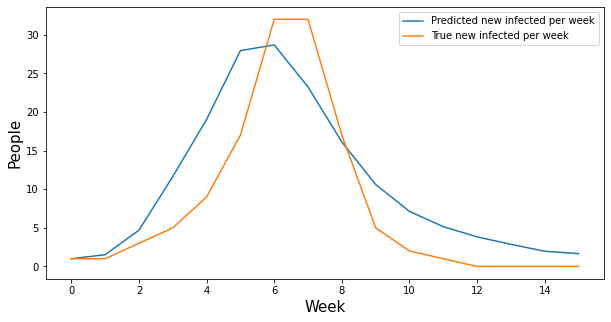

In [64]:
#plot the predicted new infected per week and the true ones chart
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["new_every_week"], label = "Predicted new infected per week")
plt.plot(I, label = "True new infected per week")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()


In [65]:
#check the RMSE of the validation
RMSE(final_results["new_every_week"], I)

5.367056921628464

# Exercise 5
We try to change the type of graph generated by using the Watts-Strogatz model to generate a small-world graph. This will also add a new parameter, p, the probability to re-wire each edge.

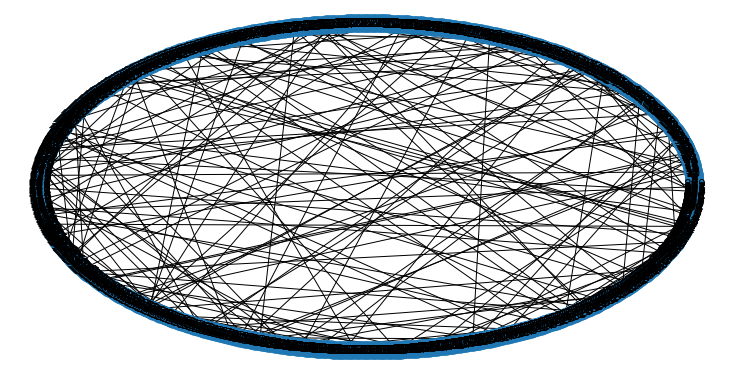

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

def build_symmetric_graph(num_nodes, degree):
    nodes = list(range(num_nodes))
    G = nx.Graph()
    for i in range(num_nodes):
        sums = np.arange(-degree//2,(degree//2) + 1 )
        
        #create connections
        for j in sums:
            if j != 0 and i<num_nodes-degree//2:
                G.add_edge(nodes[i+j],nodes[i])
                
        #link only the remaining last degree//2 nodes to each other
        if i>(num_nodes - degree // 2):
            G.add_edge(nodes[i-1],nodes[i])
    return G




def get_small_world(num_nodes, degree, p):
    if p<= 1 and p>= 0:
        #get a small world graph starting from a symmetric graph 
        G = build_symmetric_graph(num_nodes, degree)
        #number of new undirected links l
        l = int(np.random.binomial(int(num_nodes*degree/2), p, 1))
        chosen_nodes_origin = np.random.choice(num_nodes, size = l)
        for z in range(l):
            dest = chosen_nodes_origin[z]
            ori = chosen_nodes_origin[z]
            #to check the dest is not already linked to the origin
            neigh = get_neighbours(G,ori)
            while dest == ori and dest not in neigh :
                dest = int(np.random.choice(num_nodes,1))
            G.add_edge(ori,dest)
        return G
    else:
        print("P is not a probability given its value")
        return 0
    
G = get_small_world(900,4, 0.1)
pos = nx.drawing.layout.circular_layout(G)
nx.draw(G,pos,with_labels=True)

In [ ]:
vaccinated = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
I = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
num_nodes = 934
initial_number_infected = I[0]
N = 100
threshold_iterations = 50
threshold_precision = 0.1
tot_weeks = 15



#set the initial values of k, beta, ro
init_k = best_k = 10
init_beta = best_beta = 0.3
init_ro = best_ro = 0.6
init_p = best_p = 0.02
print(f"\nInitial k:{best_k}\nInitial beta:{best_beta}\nInitial rho:{best_ro}\nInitial p:{best_p}")            

#set their deltas
delta_k = 1
delta_beta = 0.1
delta_ro = 0.1
delta_p = 0.01

#create their spaces
space_k = [init_k - delta_k, init_k, init_k + delta_k]
space_beta = [init_beta - delta_beta, init_beta, init_beta + delta_beta]
space_ro = [init_ro - delta_ro, init_ro, init_ro + delta_ro]
space_p = [init_p - delta_p, init_p, init_p + delta_p]

currently_overall_best = [100, init_k, init_beta, init_ro, init_p]
for it in range(threshold_iterations):
    
    #check on the spaces 
    if best_k + delta_k > num_nodes: del space_k[-1]
    if best_k - delta_k <= 0: del space_k[0]
    if best_beta + delta_beta > 1: del space_beta[-1]
    if best_beta - delta_beta <= 0: del space_beta[0]
    if best_ro + delta_ro > 1: del space_ro[-1]
    if best_ro - delta_ro <= 0: del space_ro[0]
    if best_p + delta_p > 1: del space_p[-1]
    if best_p - delta_p <= 0: del space_p[0]
    
    
    #to keep track of the various improvements
    whole_space_results = []
    
    #iterate over the 3 spaces
    for k in space_k:
        for beta in space_beta:
            for ro in space_ro:
                for p in space_p:

                    tot_results = []

                    #now we iterate N times
                    for n in range(N):

                        #we now generate a random small-world graph 
                        G = get_small_world(num_nodes, k, p)
                        res = simulate_infection_vaccine(G, initial_number_infected, vaccinated )
                        #just to store infected
                        partial_result = []
                        for i in res:
                            partial_result.append(i[1])
                        tot_results.append(partial_result)

                    #now we average the number of infected over the N iterations
                    #sum over columns and then divide by N
                    combination_result = [sum(x) for x in zip(*tot_results)] 
                    combination_result = [x / N for x in combination_result]

                    #compute the RMSE error respect the ground truth
                    error = RMSE(combination_result, I)

                    #we now append the result in array form in order to keep track of the partial result
                    #[error, k, beta, ro]
                    returning = [error, k, beta, ro, p]
                    whole_space_results.append(returning)
    
    #now we want to find the best performing configuration of the parameters to set the new values
    min_conf_index = np.argmin(np.array(whole_space_results)[:,0])
    best_k = int(whole_space_results[min_conf_index][1])
    best_beta = whole_space_results[min_conf_index][2]
    best_ro = whole_space_results[min_conf_index][3]
    best_p = whole_space_results[min_conf_index][4]
    print(f"\nIteration :{it} | Best RMSE: {whole_space_results[min_conf_index][0]}")
    
    #create the new spaces (decrease the deltas in order get more precision)
    space_k = [best_k - delta_k, best_k, best_k + delta_k]
    space_beta = [best_beta - delta_beta/(it/2+1), best_beta, best_beta + delta_beta/(it/2+1)]
    space_ro = [best_ro - delta_ro/(it/2+1), best_ro, best_ro + delta_ro/(it/2+1)]
    space_p = [best_p - delta_p/(it/2+1), best_p, best_p + delta_p/(it/2+1)]
    print(f"\n     Configuration: k = {best_k}, beta = {best_beta}, rho = {best_ro }, p = {best_p}")

    if whole_space_results[min_conf_index][0] < currently_overall_best[0]:
        currently_overall_best = whole_space_results[min_conf_index]
        
    #if the RMSE drops under a given value we shut down the simulation
    if currently_overall_best[0] < threshold_precision:
        break
            
print(f"\nN:{N}\nBest k:{currently_overall_best[1]}\nBest beta:{currently_overall_best[2]}\
\nBest rho:{currently_overall_best[3]} \nBest p:{currently_overall_best[4]} \nRMSE: {currently_overall_best[0]}")            
            



Initial k:10
Initial beta:0.3
Initial rho:0.6
Initial p:0.02

Iteration :0 | Best RMSE: 7.56485376593626

     Configuration: k = 11, beta = 0.4, rho = 0.7, p = 0.03

Iteration :1 | Best RMSE: 6.78097706824024

     Configuration: k = 10, beta = 0.5, rho = 0.7999999999999999, p = 0.03

Iteration :2 | Best RMSE: 6.750626359827657

     Configuration: k = 10, beta = 0.5, rho = 0.7999999999999999, p = 0.03

Iteration :3 | Best RMSE: 6.612577031687419

     Configuration: k = 9, beta = 0.5, rho = 0.7999999999999999, p = 0.034999999999999996

Iteration :4 | Best RMSE: 6.517947337927794

     Configuration: k = 10, beta = 0.46, rho = 0.84, p = 0.03899999999999999

Iteration :5 | Best RMSE: 6.407704834806299

     Configuration: k = 10, beta = 0.46, rho = 0.8733333333333333, p = 0.03566666666666666

Iteration :6 | Best RMSE: 6.421051315789339

     Configuration: k = 10, beta = 0.4885714285714286, rho = 0.9019047619047619, p = 0.03566666666666666

Iteration :7 | Best RMSE: 6.407686790098279


In [14]:
I = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
num_nodes = 934
tot_weeks = 15
N = 100
#is the fraction of the population which had received the vaccine at the given time
vaccinated = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]

#the values selected here are the best perfoming ones returned from our searches
k = 10
beta = 0.47061654897103833
ro = 0.9009205122811261
p = 0.044826330961779876
initial_number_infected = I[0]
total_results = []

for n in range(N):
    G = nx.generators.random_graphs.newman_watts_strogatz_graph(num_nodes, k, p, seed=42)
    single_results = simulate_infection_vaccine(G,initial_number_infected, vaccinated)
    total_results.append(single_results)
    
final_results = {"new_every_week":[], "susceptible":[],"infected":[],"recovered":[], "vaccinated":[], "new_vaccinated":[]}
weeks = list(range(16))

for week in range(16):
    tot_new_infection = 0
    tot_susceptible = 0
    tot_infected = 0
    tot_recovered = 0
    tot_vaccinated = 0
    tot_new_vaccinated = 0
    
    for n in range(N):
        tot_new_infection += total_results[n][week][1]
        tot_susceptible += total_results[n][week][3]
        tot_infected += total_results[n][week][4]
        tot_recovered += total_results[n][week][5]
        tot_vaccinated += total_results[n][week][6]
        tot_new_vaccinated += total_results[n][week][7]


    
    final_results["new_every_week"].append(tot_new_infection)
    final_results["susceptible"].append(tot_susceptible)
    final_results["infected"].append(tot_infected)
    final_results["recovered"].append(tot_recovered)
    final_results["vaccinated"].append(tot_vaccinated)
    final_results["new_vaccinated"].append(tot_new_vaccinated)


#averaging over total runs
final_results["new_every_week"] = [x / N for x in final_results["new_every_week"]]
final_results["susceptible"] = [x / N for x in final_results["susceptible"]]
final_results["infected"] = [x / N for x in final_results["infected"]]
final_results["recovered"] = [x / N for x in final_results["recovered"]]
final_results["vaccinated"] = [x / N for x in final_results["vaccinated"]]
final_results["new_vaccinated"] = [x / N for x in final_results["new_vaccinated"]]

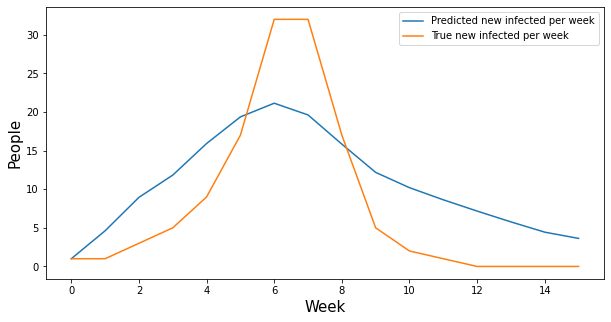

In [15]:
#plot the predicted new infected per week and the true ones chart
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(final_results["new_every_week"], label = "Predicted new infected per week")
plt.plot(I, label = "True new infected per week")
plt.xlabel("Week", fontsize = 15)
plt.ylabel("People",fontsize = 15)
ax.legend()

In [16]:
#check the RMSE of the validation
RMSE(final_results["new_every_week"], I)

6.688657843693307